In [1]:
model_name = 'lightgbm'
device = 'cpu'
min_samples_per_class = 5
n_classes = 3
n_frac = 0.005
n_trials_tpe = 10
plot_param_importances = False
timeout_tpe = 60
random_state = 42
n_jobs = -1

In [2]:
# Parameters
model_name = "xgboost"
device = "cpu"
min_samples_per_class = 5
n_classes = 34
n_frac = 0.1
n_trials_tpe = 1000
plot_param_importances = False
timeout_tpe = 3600
random_state = 42
n_jobs = -1


In [3]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# UTILS

In [4]:
def stratified_sample_df(df, stratify_col, frac, min_samples_per_class, random_state):
    grouped = df.groupby(stratify_col)
    sample = grouped.apply(
        lambda x: x.sample(
            n=max(min_samples_per_class, int(len(x) * frac)), 
            replace=len(x) < max(min_samples_per_class, int(len(x) * frac)),
            random_state=random_state
        )
    ).reset_index(drop=True)
    return sample

In [5]:
def build_classifier(extra_kwargs={}):
    clf = None
    if model_name in ['lgbm', 'lightgbm']:
        import lightgbm as lgb
        kwargs = {
            'device_type': device,
            'n_jobs': n_jobs,
            'objective': 'binary' if n_classes == 2 else 'multiclass',
            'random_state': random_state,
            'verbose': 1,
            **extra_kwargs
        }
        if n_classes > 2:
            kwargs['num_class'] = n_classes
        clf = lgb.LGBMClassifier(**kwargs)
    elif model_name in ['xgb', 'xgboost']:
        from xgboost import XGBClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBClassifier(**kwargs)
    elif model_name in ['xgbrf', 'xgboostrf']:
        from xgboost import XGBRFClassifier
        kwargs = {
            'device': device,
            'eval_metric': 'logloss' if n_classes == 2 else 'mlogloss',
            'n_jobs': n_jobs,
            'random_state': random_state,
            'tree_method': 'hist',
            **extra_kwargs
        }
        clf = XGBRFClassifier(**kwargs)
    return clf

In [6]:
from collections import OrderedDict
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def process_metrics(y_test, y_pred):
    
    accuracy = accuracy_score(y_test, y_pred)
    
    precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
    precision_micro = precision_score(y_test, y_pred, average='micro', zero_division=0)
    precision_weighted = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    
    recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
    recall_micro = recall_score(y_test, y_pred, average='micro', zero_division=0)
    recall_weighted = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    
    f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
    f1_micro = f1_score(y_test, y_pred, average='micro', zero_division=0)
    f1_weighted = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    
    results = OrderedDict({
        'Accuracy': accuracy,
        'Precision (Macro)': precision_macro,
        'Precision (Micro)': precision_micro,
        'Precision (Weighted)': precision_weighted,
        'Recall (Macro)': recall_macro,
        'Recall (Micro)': recall_micro,
        'Recall (Weighted)': recall_weighted,
        'F1 (Macro)': f1_macro,
        'F1 (Micro)': f1_micro,
        'F1 (Weighted)': f1_weighted
    })

    pprint(results, indent=4)

In [7]:
from sklearn.metrics import classification_report

def process_classification_report(y_test, y_pred):
    try:
        cr = classification_report(y_test, y_pred, digits=6, target_names=labels)
        print(cr)
    except Exception as e:
        print('Cloud not build/show classification report. Reason:', e)

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def process_confusion_matrix(y_test, y_pred):
    try:
        y_test_decoded = [index_to_label[label] for label in y_test]
        y_pred_decoded = [index_to_label[label] for label in y_pred]
        cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)
        cm = np.round(cm / 1000, 1)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot(values_format='g')
    except Exception as e:
        print('Cloud not build/show confusion matrix. Reason:', e)

In [9]:
import numpy as np

def value_counts_to_dict(array):
    unique, counts = np.unique(array, return_counts=True)
    value_counts_dict = dict(zip(unique, counts))
    return value_counts_dict

# STEP 1: DATA PREP

In [10]:
# %load_ext cudf.pandas
import numpy as np
import pandas as pd
from pprint import pprint

if n_classes == 3: # dummy dataset
    df_sample = pd.read_parquet('input/dummy.parquet')
else:
    df_sample = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_sample['label'], unique_values = df_sample['label'].factorize()

label_to_index = {value: i for i, value in enumerate(unique_values)}
index_to_label = {v: k for k, v in label_to_index.items()}
labels = list(label_to_index.keys())
pprint(label_to_index, indent=4)

{   'Backdoor_Malware': 28,
    'BenignTraffic': 12,
    'BrowserHijacking': 29,
    'CommandInjection': 25,
    'DDoS-ACK_Fragmentation': 14,
    'DDoS-HTTP_Flood': 23,
    'DDoS-ICMP_Flood': 2,
    'DDoS-ICMP_Fragmentation': 17,
    'DDoS-PSHACK_Flood': 9,
    'DDoS-RSTFINFlood': 0,
    'DDoS-SYN_Flood': 8,
    'DDoS-SlowLoris': 27,
    'DDoS-SynonymousIP_Flood': 6,
    'DDoS-TCP_Flood': 10,
    'DDoS-UDP_Flood': 11,
    'DDoS-UDP_Fragmentation': 20,
    'DNS_Spoofing': 19,
    'DictionaryBruteForce': 30,
    'DoS-HTTP_Flood': 16,
    'DoS-SYN_Flood': 4,
    'DoS-TCP_Flood': 1,
    'DoS-UDP_Flood': 3,
    'MITM-ArpSpoofing': 13,
    'Mirai-greeth_flood': 5,
    'Mirai-greip_flood': 15,
    'Mirai-udpplain': 7,
    'Recon-HostDiscovery': 24,
    'Recon-OSScan': 21,
    'Recon-PingSweep': 32,
    'Recon-PortScan': 18,
    'SqlInjection': 31,
    'Uploading_Attack': 33,
    'VulnerabilityScan': 26,
    'XSS': 22}


In [11]:
# not stratified df sampling (just to check)
df_sample['label'].sample(frac=n_frac, random_state=random_state).value_counts()

label
2     719277
11    541364
10    449555
9     408612
8     405906
0     404604
6     360036
3     331222
1     267964
4     202777
12    109844
5      99055
7      89251
15     75698
17     45342
13     30994
14     28637
20     28614
19     17843
24     13529
21      9921
18      8279
16      7318
26      3699
23      2860
27      2402
30      1267
29       619
25       557
31       521
22       369
28       337
32       249
33       136
Name: count, dtype: int64

In [12]:
# stratified df sampling
df_sample = stratified_sample_df(df_sample, 'label', n_frac, min_samples_per_class, random_state)

/tmp/ipykernel_2681293/2006267505.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample = grouped.apply(


In [13]:
df_sample['label'].value_counts()

label
2     720050
11    541228
10    449766
9     409475
8     405919
0     404528
6     359813
3     331859
1     267144
4     202883
12    109819
5      99186
7      89057
15     75168
17     45248
13     30759
20     28692
14     28510
19     17891
24     13437
21      9825
18      8228
16      7186
26      3738
23      2879
27      2342
30      1306
29       585
25       540
31       524
22       384
28       321
32       226
33       125
Name: count, dtype: int64

In [14]:
X_sample = df_sample.drop('label', axis=1)

print(type(X_sample))
print(X_sample.shape)
print(X_sample.dtypes)

<class 'pandas.core.frame.DataFrame'>
(4668641, 46)
flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float32
HTTPS              float32
DNS                float32
Telnet             float32
SMTP               float32
SSH                float32
IRC                float32
TCP                float32
UDP                float32
DHCP               float32
ARP                float32
ICMP               float32
IPv                float32
LLC                float32
Tot sum            float32
Min                float32
Max

In [15]:
y_sample = df_sample['label']

print(type(y_sample))
print(y_sample.shape)
print(y_sample.dtype)
print(y_sample.unique())
print(y_sample.nunique())
y_sample.value_counts()

<class 'pandas.core.series.Series'>
(4668641,)
int64
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
34


label
2     720050
11    541228
10    449766
9     409475
8     405919
0     404528
6     359813
3     331859
1     267144
4     202883
12    109819
5      99186
7      89057
15     75168
17     45248
13     30759
20     28692
14     28510
19     17891
24     13437
21      9825
18      8228
16      7186
26      3738
23      2879
27      2342
30      1306
29       585
25       540
31       524
22       384
28       321
32       226
33       125
Name: count, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split

# Split into 80% training+validation and 20% test
X_sample_train_val, X_sample_test, y_sample_train_val, y_sample_test = train_test_split(
    X_sample, y_sample, test_size=0.2, random_state=random_state, stratify=y_sample
)

# Split the 80% training+validation set into 75% training and 25% validation
X_sample_train, X_sample_val, y_sample_train, y_sample_val = train_test_split(
    X_sample_train_val, y_sample_train_val, test_size=0.25, random_state=random_state, stratify=y_sample_train_val
)

# Verify the sizes of the splits
print(f'Training   : {len(X_sample_train)}\t({(100.0 * len(X_sample_train) / len(X_sample)):.2f}) %\t{sorted(y_sample_train.unique())}')
print(f'Validation : {len(X_sample_val)}\t({(100.0 * len(X_sample_val) / len(X_sample)):.2f}) %\t{sorted(y_sample_val.unique())}')
print(f'Test       : {len(X_sample_test)}\t({(100.0 * len(X_sample_test) / len(X_sample)):.2f}) %\t{sorted(y_sample_test.unique())}')

Training   : 2801184	(60.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Validation : 933728	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Test       : 933729	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [17]:
assert sorted(y_sample_train.unique()) == sorted(y_sample_val.unique())
assert sorted(y_sample_train.unique()) == sorted(y_sample_test.unique())
assert sorted(y_sample_val.unique()) == sorted(y_sample_test.unique())

# STEP 2: PREPROCESSING & FEATURE SELECTION

### Preprocessing Methods

In [18]:
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, RobustScaler, StandardScaler

class DummyPreprocessor:
    def fit(self, _X, _y=None):
        return self
    def transform(self, _X):
        return _X

def make_preprocessor(pp_method):
    preprocessor = None
    if pp_method == 'none':
        preprocessor = DummyPreprocessor()
    if pp_method == 'maxabs':
        preprocessor = MaxAbsScaler()
    elif pp_method == 'minmax':
        preprocessor = MinMaxScaler()
    elif pp_method == 'norm':
        preprocessor = Normalizer()
    elif pp_method == 'robust':
        preprocessor = RobustScaler()
    elif pp_method == 'standard':
        preprocessor = StandardScaler()
    return preprocessor

### Feature Selection Methods

In [19]:
from shaphypetune import BoostSearch, BoostBoruta, BoostRFE, BoostRFA

class DummyFeatureSelector:
    def fit(self, _X, _y, _eval_set=None):
        self.support_ = np.ones(_X.shape[1], dtype=bool)
        return self
    def transform(self, _X):
        return _X[:, self.support_]

def make_feature_selector(fs_method, fs_metric):
    feature_selector = None
    if fs_method == 'none':
        feature_selector = DummyFeatureSelector()
    elif fs_method == 'boruta':
        feature_selector = BoostBoruta(build_classifier(), importance_type=fs_metric, perc=100, sampling_seed=random_state)
    elif fs_method == 'rfa':
        feature_selector = BoostRFA(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    elif fs_method == 'rfe':
        feature_selector = BoostRFE(build_classifier(), importance_type=fs_metric, min_features_to_select=1, sampling_seed=random_state, step=1)
    return feature_selector

### HPO

In [20]:
%%time

import optuna

from optuna.samplers import GridSampler

def objective(trial):

    try:
        # preprocessing hyperparameters
        pp_method = trial.suggest_categorical('pp_method', ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'])

        # feature selection hyperparameters
        fs_method = trial.suggest_categorical('fs_method', ['none', 'boruta', 'rfa', 'rfe'])
        fs_metric = trial.suggest_categorical('fs_metric', ['feature_importances', 'shap_importances'])
        
        # pipeline - preprocessing
        preprocessor = make_preprocessor(pp_method)
        preprocessor.fit(X_sample_train)
        X_sample_train_prep = pd.DataFrame(preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
        X_sample_val_prep = pd.DataFrame(preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
        X_sample_test_prep = pd.DataFrame(preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)
    
        # pipeline - feature selection
        feature_selector = make_feature_selector(fs_method, fs_metric)
        feature_selector.fit(X_sample_train_prep, y_sample_train, eval_set=[(X_sample_val_prep, y_sample_val)])
        selected_features = X_sample_train_prep.columns[feature_selector.support_]
        trial.set_user_attr('selected_features', selected_features)
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_prep[selected_features], y_sample_train)
        y_sample_pred = model.predict(X_sample_test_prep[selected_features])
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'pp_method': ['none', 'maxabs', 'minmax', 'norm', 'robust', 'standard'],
    'fs_method': ['boruta', 'rfa', 'rfe'],
    'fs_metric': ['feature_importances', 'shap_importances']
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2024-07-15 16:57:03,945] A new study created in memory with name: no-name-4c336aa3-496f-44aa-86e6-bd549c76ec84


[I 2024-07-15 17:16:37,515] Trial 0 finished with value: 0.756063810902224 and parameters: {'pp_method': 'minmax', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 0 with value: 0.756063810902224.


[I 2024-07-15 17:37:49,232] Trial 1 pruned. 


index 19 is out of bounds for axis 0 with size 12


[I 2024-07-15 17:59:34,296] Trial 2 pruned. 


index 22 is out of bounds for axis 0 with size 12


[I 2024-07-15 18:54:56,916] Trial 3 finished with value: 0.7583883504893388 and parameters: {'pp_method': 'standard', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 3 with value: 0.7583883504893388.


[I 2024-07-15 19:51:42,070] Trial 4 finished with value: 0.7992700375154522 and parameters: {'pp_method': 'norm', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7992700375154522.


[I 2024-07-15 20:14:42,566] Trial 5 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-15 20:37:43,900] Trial 6 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-15 22:23:45,228] Trial 7 finished with value: 0.7557379614688126 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7992700375154522.


[I 2024-07-15 22:46:24,974] Trial 8 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-15 22:59:40,392] Trial 9 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-15 23:21:25,825] Trial 10 pruned. 


index 28 is out of bounds for axis 0 with size 12


[I 2024-07-15 23:35:45,680] Trial 11 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-16 01:21:32,851] Trial 12 finished with value: 0.7557379614688126 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7992700375154522.


[I 2024-07-16 01:42:50,137] Trial 13 pruned. 


index 13 is out of bounds for axis 0 with size 12


[I 2024-07-16 02:05:14,149] Trial 14 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-16 03:01:42,806] Trial 15 finished with value: 0.7563598829736763 and parameters: {'pp_method': 'minmax', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7992700375154522.


[I 2024-07-16 04:47:09,571] Trial 16 finished with value: 0.7557379614688126 and parameters: {'pp_method': 'none', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7992700375154522.


[I 2024-07-16 05:07:20,695] Trial 17 finished with value: 0.756063810902224 and parameters: {'pp_method': 'maxabs', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7992700375154522.


[I 2024-07-16 06:56:48,510] Trial 18 finished with value: 0.7984252705498704 and parameters: {'pp_method': 'norm', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7992700375154522.


[I 2024-07-16 07:19:24,544] Trial 19 pruned. 


index 31 is out of bounds for axis 0 with size 12


[I 2024-07-16 07:32:20,317] Trial 20 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-16 07:45:29,774] Trial 21 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-16 08:06:55,885] Trial 22 pruned. 


index 17 is out of bounds for axis 0 with size 12


[I 2024-07-16 08:28:43,899] Trial 23 finished with value: 0.7977847140465181 and parameters: {'pp_method': 'norm', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7992700375154522.


[I 2024-07-16 10:14:57,722] Trial 24 finished with value: 0.7572663042626862 and parameters: {'pp_method': 'standard', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7992700375154522.


[I 2024-07-16 10:34:19,059] Trial 25 finished with value: 0.757523494203346 and parameters: {'pp_method': 'standard', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7992700375154522.


[I 2024-07-16 11:29:57,162] Trial 26 finished with value: 0.7562825091832992 and parameters: {'pp_method': 'robust', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7992700375154522.


[I 2024-07-16 11:49:30,034] Trial 27 finished with value: 0.7562825091832992 and parameters: {'pp_method': 'robust', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7992700375154522.


[I 2024-07-16 12:51:59,738] Trial 28 finished with value: 0.7563598829736763 and parameters: {'pp_method': 'none', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7992700375154522.


[I 2024-07-16 13:15:14,198] Trial 29 pruned. 


index 15 is out of bounds for axis 0 with size 12


[I 2024-07-16 15:01:29,204] Trial 30 finished with value: 0.7562825091832992 and parameters: {'pp_method': 'robust', 'fs_method': 'rfa', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7992700375154522.


[I 2024-07-16 15:14:19,857] Trial 31 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-16 16:10:08,277] Trial 32 finished with value: 0.7563598829736763 and parameters: {'pp_method': 'maxabs', 'fs_method': 'rfe', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7992700375154522.


[I 2024-07-16 16:23:32,906] Trial 33 pruned. 


shape mismatch: value array of shape (46,34) could not be broadcast to indexing result of shape (46,)


[I 2024-07-16 16:47:36,555] Trial 34 pruned. 


index 27 is out of bounds for axis 0 with size 12


[I 2024-07-16 17:07:08,446] Trial 35 finished with value: 0.756063810902224 and parameters: {'pp_method': 'none', 'fs_method': 'boruta', 'fs_metric': 'feature_importances'}. Best is trial 4 with value: 0.7992700375154522.


CPU times: user 61d 8h 12min 4s, sys: 38min 57s, total: 61d 8h 51min 1s
Wall time: 1d 10min 4s


In [21]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.756064 2024-07-15 16:57:03.945787 2024-07-15 17:16:37.514806   
1        1       NaN 2024-07-15 17:16:37.515943 2024-07-15 17:37:49.232370   
2        2       NaN 2024-07-15 17:37:49.233259 2024-07-15 17:59:34.296445   
3        3  0.758388 2024-07-15 17:59:34.297305 2024-07-15 18:54:56.916028   
4        4  0.799270 2024-07-15 18:54:56.916879 2024-07-15 19:51:42.069961   
5        5       NaN 2024-07-15 19:51:42.070829 2024-07-15 20:14:42.566312   
6        6       NaN 2024-07-15 20:14:42.567123 2024-07-15 20:37:43.900882   
7        7  0.755738 2024-07-15 20:37:43.901597 2024-07-15 22:23:45.228183   
8        8       NaN 2024-07-15 22:23:45.229253 2024-07-15 22:46:24.974115   
9        9       NaN 2024-07-15 22:46:24.975026 2024-07-15 22:59:40.392092   
10      10       NaN 2024-07-15 22:59:40.392842 2024-07-15 23:21:25.825192   
11      11       NaN 2024-07-15 23:21:25.826116 2024-07-15 23:35:45.680862   
12      12  0.755738 2024-07-15 23:35:45.681597 2024-07-16 01:21:32.851159   
13      13       NaN 2024-07-16 01:21:32.852227 2024-07-16 01:42:50.137786   
14      14       NaN 2024-07-16 01:42:50.138703 2024-07-16 02:05:14.149690   
15      15  0.756360 2024-07-16 02:05:14.150520 2024-07-16 03:01:42.806101   
16      16  0.755738 2024-07-16 03:01:42.806772 2024-07-16 04:47:09.570994   
17      17  0.756064 2024-07-16 04:47:09.571858 2024-07-16 05:07:20.695635   
18      18  0.798425 2024-07-16 05:07:20.696681 2024-07-16 06:56:48.509847   
19      19       NaN 2024-07-16 06:56:48.510751 2024-07-16 07:19:24.543977   
20      20       NaN 2024-07-16 07:19:24.544498 2024-07-16 07:32:20.317117   
21      21       NaN 2024-07-16 07:32:20.317837 2024-07-16 07:45:29.774531   
22      22       NaN 2024-07-16 07:45:29.775421 2024-07-16 08:06:55.885016   
23      23  0.797785 2024-07-16 08:06:55.885897 2024-07-16 08:28:43.898867   
24      24  0.757266 2024-07-16 08:28:43.899917 2024-07-16 10:14:57.722641   
25      25  0.757523 2024-07-16 10:14:57.723422 2024-07-16 10:34:19.059681   
26      26  0.756283 2024-07-16 10:34:19.060757 2024-07-16 11:29:57.162147   
27      27  0.756283 2024-07-16 11:29:57.163220 2024-07-16 11:49:30.034784   
28      28  0.756360 2024-07-16 11:49:30.035855 2024-07-16 12:51:59.738490   
29      29       NaN 2024-07-16 12:51:59.739567 2024-07-16 13:15:14.198036   
30      30  0.756283 2024-07-16 13:15:14.198922 2024-07-16 15:01:29.204140   
31      31       NaN 2024-07-16 15:01:29.205193 2024-07-16 15:14:19.856919   
32      32  0.756360 2024-07-16 15:14:19.857708 2024-07-16 16:10:08.277293   
33      33       NaN 2024-07-16 16:10:08.278388 2024-07-16 16:23:32.906032   
34      34       NaN 2024-07-16 16:23:32.906796 2024-07-16 16:47:36.555694   
35      35  0.756064 2024-07-16 16:47:36.556499 2024-07-16 17:07:08.446537   

                 duration params_fs_method     params_fs_metric  \
0  0 days 00:19:33.569019           boruta  feature_importances   
1  0 days 00:21:11.716427              rfe     shap_importances   
2  0 days 00:21:45.063186              rfe     shap_importances   
3  0 days 00:55:22.618723              rfe  feature_importances   
4  0 days 00:56:45.153082              rfe  feature_importances   
5  0 days 00:23:00.495483              rfa     shap_importances   
6  0 days 00:23:01.333759              rfa     shap_importances   
7  0 days 01:46:01.326586              rfa  feature_importances   
8  0 days 00:22:39.744862              rfa     shap_importances   
9  0 days 00:13:15.417066           boruta     shap_importances   
10 0 days 00:21:45.432350              rfe     shap_importances   
11 0 days 00:14:19.854746           boruta     shap_importances   
12 0 days 01:45:47.169562              rfa  feature_importances   
13 0 days 00:21:17.285559              rfe     shap_importances   
14 0 days 00:22:24.010987              rfa     shap_importances   
15 0 days 00:56:28.655581              rfe  f

In [22]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [23]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [24]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [25]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

[W 2024-07-16 17:07:09,465] Param fs_metric unique value length is less than 2.


[W 2024-07-16 17:07:09,466] Param fs_metric unique value length is less than 2.


[W 2024-07-16 17:07:09,466] Param fs_metric unique value length is less than 2.


[W 2024-07-16 17:07:09,466] Param fs_metric unique value length is less than 2.


In [26]:
best_preprocessor = make_preprocessor(study.best_trial.params['pp_method'])
best_preprocessor.fit(X_sample_train)
X_sample_train = pd.DataFrame(best_preprocessor.transform(X_sample_train.copy()), columns=X_sample_train.columns)
X_sample_val = pd.DataFrame(best_preprocessor.transform(X_sample_val.copy()), columns=X_sample_val.columns)
X_sample_test = pd.DataFrame(best_preprocessor.transform(X_sample_test.copy()), columns=X_sample_test.columns)

best_selected_features = study.best_trial.user_attrs['selected_features']
X_sample_train = X_sample_train[best_selected_features]
X_sample_val = X_sample_val[best_selected_features]
X_sample_test = X_sample_test[best_selected_features]

# STEP 3: DATA BALANCING

### Oversampling

In [27]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.over_sampling import *

def build_oversampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_generate = {
            class_: perfectly_balanced_occurences - occ
                    if occ < perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_generate = {
            class_: int(min(occ * threshold, perfectly_balanced_occurences - occ))
            if occ < perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_generate

def patch_oversampling_strategy(value_counts, n_generate):
    return {k : (value_counts[k] + n_generate[k]) for k in value_counts.keys()}

def make_over_sampler(over_strategy):
    over_sampler = RandomOverSampler(
        random_state=random_state, sampling_strategy=over_strategy)
    return over_sampler

### Undersampling

In [28]:
# from cuml.neighbors import KNeighborsClassifier
# from cuml.neighbors import NearestNeighbors
from imblearn.under_sampling import *

def build_undersampling_strategy(value_counts, threshold):
    n_occurences = sum([n for n in value_counts.values()])
    perfectly_balanced_occurences = int(n_occurences / len(value_counts.keys()))
    if threshold == "auto":
        n_remove = {
            class_: occ - perfectly_balanced_occurences
                    if occ > perfectly_balanced_occurences else 0
                    for class_, occ in value_counts.items()
        }
    else:
        n_remove = {
            class_: int(min(occ * threshold, occ - perfectly_balanced_occurences))
            if occ > perfectly_balanced_occurences else 0
            for class_, occ in value_counts.items()
        }
    return n_remove

def patch_undersampling_strategy(value_counts, n_remove):
    return {k : (value_counts[k] - n_remove[k]) for k in value_counts.keys()}

def make_under_sampler(under_strategy):
    under_sampler = RandomUnderSampler(
        random_state=random_state, sampling_strategy=under_strategy)
    return under_sampler

### Combination

In [29]:
def fit_resample(_X_train, _y_train, over_thresh, under_thresh):

    _X_names = _X_train.columns.tolist()
    _y_name = _y_train.name
    
    _X_train_copy = _X_train.copy()
    _y_train_copy = _y_train.copy()

    if over_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_generate = build_oversampling_strategy(value_counts, over_thresh)
        over_strategy = patch_oversampling_strategy(value_counts, n_generate)
        over_sampler = make_over_sampler(over_strategy)
        _X_train_copy, _y_train_copy = over_sampler.fit_resample(_X_train_copy, _y_train_copy)

    if under_thresh:
        value_counts = value_counts_to_dict(_y_train_copy)
        n_remove = build_undersampling_strategy(value_counts, under_thresh)
        under_strategy = patch_undersampling_strategy(value_counts, n_remove)
        under_sampler = make_under_sampler(under_strategy)
        _X_train_copy, _y_train_copy = under_sampler.fit_resample(_X_train_copy, _y_train_copy)

    return pd.DataFrame(_X_train_copy, columns=_X_names), pd.Series(_y_train_copy, name=_y_name)

### HPO

In [30]:
from itertools import chain

over_threshold_choices = list(chain(*[np.linspace(0, 4, num=17).round(2), ['auto']]))
under_threshold_choices = list(chain(*[np.linspace(0, 0.95, num=20).round(2), ['auto']]))

In [31]:
%%time
def objective(trial):

    try:
        # data balancing hyperparameters
        over_threshold = trial.suggest_categorical('over_threshold', over_threshold_choices)
        under_threshold = trial.suggest_categorical('under_threshold', under_threshold_choices)
    
        # pipeline - data balancing
        X_sample_train_bal, y_sample_train_bal = fit_resample(
            X_sample_train, y_sample_train, over_threshold, under_threshold
        )
        
        # pipeline - classifier fit/predict
        model = build_classifier()
        model.fit(X_sample_train_bal, y_sample_train_bal)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)

    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a Grid sampler
search_space = {
    'over_threshold': over_threshold_choices,
    'under_threshold': under_threshold_choices
}
sampler = GridSampler(search_space)
n_trials_grid = np.prod([len(v) for v in search_space.values()])
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_grid)

[I 2024-07-16 17:07:11,052] A new study created in memory with name: no-name-c44bcafb-25e4-4b50-886e-119c93d87474


[I 2024-07-16 17:08:05,860] Trial 0 finished with value: 0.8357618086772084 and parameters: {'over_threshold': 2.5, 'under_threshold': 'auto'}. Best is trial 0 with value: 0.8357618086772084.


[I 2024-07-16 17:09:03,837] Trial 1 finished with value: 0.8189933935830099 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.65}. Best is trial 0 with value: 0.8357618086772084.


[I 2024-07-16 17:10:09,093] Trial 2 finished with value: 0.8389032083062314 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.5}. Best is trial 2 with value: 0.8389032083062314.


[I 2024-07-16 17:11:21,630] Trial 3 finished with value: 0.8060596195644357 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.15}. Best is trial 2 with value: 0.8389032083062314.


[I 2024-07-16 17:12:20,683] Trial 4 finished with value: 0.830485826964924 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.65}. Best is trial 2 with value: 0.8389032083062314.


[I 2024-07-16 17:13:40,841] Trial 5 finished with value: 0.8054067033857334 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.05}. Best is trial 2 with value: 0.8389032083062314.


[I 2024-07-16 17:14:49,160] Trial 6 finished with value: 0.8307691738423069 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.35}. Best is trial 2 with value: 0.8389032083062314.


[I 2024-07-16 17:16:03,739] Trial 7 finished with value: 0.8444904316773676 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.3}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:16:53,838] Trial 8 finished with value: 0.8141473686376185 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.9}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:17:59,498] Trial 9 finished with value: 0.813796906525522 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.4}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:18:57,250] Trial 10 finished with value: 0.8139021522728315 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.85}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:20:13,568] Trial 11 finished with value: 0.8246800270474747 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.15}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:21:33,873] Trial 12 finished with value: 0.8253020463051008 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.1}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:22:33,876] Trial 13 finished with value: 0.8351619661317813 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.75}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:23:42,199] Trial 14 finished with value: 0.8188205316150858 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.4}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:24:40,656] Trial 15 finished with value: 0.8182470693732299 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.7}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:25:36,382] Trial 16 finished with value: 0.8243872248064958 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.95}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:26:46,228] Trial 17 finished with value: 0.8428833036888544 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.4}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:27:58,582] Trial 18 finished with value: 0.8118430174881404 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.25}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:29:37,712] Trial 19 finished with value: 0.8413517474586576 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.05}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:30:39,995] Trial 20 finished with value: 0.8315019635320102 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.5}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:31:45,674] Trial 21 finished with value: 0.8242332414703198 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.5}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:32:50,633] Trial 22 finished with value: 0.8252399748599762 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.45}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:34:12,831] Trial 23 finished with value: 0.8332089858753065 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.1}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:34:58,711] Trial 24 finished with value: 0.8118565027523382 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.65}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:36:16,699] Trial 25 finished with value: 0.823830389712447 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.2}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:36:56,868] Trial 26 finished with value: 0.8081307562903991 and parameters: {'over_threshold': 0.0, 'under_threshold': 'auto'}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:37:37,136] Trial 27 finished with value: 0.8153745527781571 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.8}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:38:46,191] Trial 28 finished with value: 0.8283670180727791 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.25}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:39:39,785] Trial 29 finished with value: 0.8240365254034941 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.85}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:40:45,459] Trial 30 finished with value: 0.8198998413772486 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.45}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:42:01,892] Trial 31 finished with value: 0.8198648469504634 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.15}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:43:30,228] Trial 32 finished with value: 0.84403450890675 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.75}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:44:45,881] Trial 33 finished with value: 0.8004259640140552 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.2}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:45:56,147] Trial 34 finished with value: 0.8087162785080015 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.2}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:46:58,203] Trial 35 finished with value: 0.8156215053750077 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.4}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:48:14,370] Trial 36 finished with value: 0.7992700375154522 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.0}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:49:08,301] Trial 37 finished with value: 0.8302629884048272 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.6}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:50:21,273] Trial 38 finished with value: 0.8134959215272511 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.25}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:51:04,678] Trial 39 finished with value: 0.8053558458225458 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.85}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:51:58,448] Trial 40 finished with value: 0.8261882839425789 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.6}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:53:21,106] Trial 41 finished with value: 0.8101827421479049 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.05}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:54:08,826] Trial 42 finished with value: 0.8126231089219741 and parameters: {'over_threshold': 0.75, 'under_threshold': 'auto'}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:55:08,806] Trial 43 finished with value: 0.8303436835252005 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.95}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:55:59,158] Trial 44 finished with value: 0.8207259545750504 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.75}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:56:45,661] Trial 45 finished with value: 0.8304941853685901 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.95}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:58:14,125] Trial 46 finished with value: 0.8231862697258734 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.0}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 17:59:40,584] Trial 47 finished with value: 0.84403450890675 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.85}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 18:00:36,412] Trial 48 finished with value: 0.8440966803356483 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.75}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 18:01:21,671] Trial 49 finished with value: 0.8137470970473623 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.7}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 18:02:20,943] Trial 50 finished with value: 0.8290984178923982 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.45}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 18:03:10,850] Trial 51 finished with value: 0.8157725910275859 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.65}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 18:04:22,589] Trial 52 finished with value: 0.8125413088824849 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.25}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 18:05:40,165] Trial 53 finished with value: 0.8215694518543843 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.15}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 18:06:34,908] Trial 54 finished with value: 0.8324154213587449 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.65}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 18:07:59,067] Trial 55 finished with value: 0.8177655465539215 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.0}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 18:09:18,728] Trial 56 finished with value: 0.8099941399068947 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.25}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 18:10:42,608] Trial 57 finished with value: 0.8058429195230905 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.0}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 18:11:36,435] Trial 58 finished with value: 0.8240365254034941 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.95}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 18:12:37,366] Trial 59 finished with value: 0.8298675769835171 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.65}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 18:13:41,000] Trial 60 finished with value: 0.8173368176984578 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.5}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 18:15:07,398] Trial 61 finished with value: 0.8284914590332801 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.0}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 18:15:58,249] Trial 62 finished with value: 0.8226270093530753 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.9}. Best is trial 7 with value: 0.8444904316773676.


[I 2024-07-16 18:18:28,001] Trial 63 finished with value: 0.8454862427183093 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.0}. Best is trial 63 with value: 0.8454862427183093.


[I 2024-07-16 18:19:48,491] Trial 64 finished with value: 0.8129535839946384 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.1}. Best is trial 63 with value: 0.8454862427183093.


[I 2024-07-16 18:20:28,972] Trial 65 finished with value: 0.8081307562903991 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.95}. Best is trial 63 with value: 0.8454862427183093.


[I 2024-07-16 18:21:30,708] Trial 66 finished with value: 0.8143385278042456 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.45}. Best is trial 63 with value: 0.8454862427183093.


[I 2024-07-16 18:22:25,381] Trial 67 finished with value: 0.8022718725079256 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.4}. Best is trial 63 with value: 0.8454862427183093.


[I 2024-07-16 18:23:07,098] Trial 68 finished with value: 0.8151397468984961 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.65}. Best is trial 63 with value: 0.8454862427183093.


[I 2024-07-16 18:24:17,685] Trial 69 finished with value: 0.8119551742587929 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.3}. Best is trial 63 with value: 0.8454862427183093.


[I 2024-07-16 18:25:09,896] Trial 70 finished with value: 0.8047979163665859 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.55}. Best is trial 63 with value: 0.8454862427183093.


[I 2024-07-16 18:26:09,210] Trial 71 finished with value: 0.8503371483507263 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.7}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:27:25,288] Trial 72 finished with value: 0.816555898678436 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.15}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:28:52,078] Trial 73 finished with value: 0.8239657625908807 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.0}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:30:19,405] Trial 74 finished with value: 0.84403450890675 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.7}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:31:33,842] Trial 75 finished with value: 0.8096404757035262 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.2}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:32:19,936] Trial 76 finished with value: 0.8304941853685901 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.85}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:33:18,851] Trial 77 finished with value: 0.8072904262654795 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.5}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:34:21,546] Trial 78 finished with value: 0.8108984696838897 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.5}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:35:15,930] Trial 79 finished with value: 0.8215656997032069 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.65}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:36:16,790] Trial 80 finished with value: 0.8421000412821398 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.6}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:37:06,318] Trial 81 finished with value: 0.8153549139150056 and parameters: {'over_threshold': 1.0, 'under_threshold': 'auto'}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:38:00,947] Trial 82 finished with value: 0.8243872248064958 and parameters: {'over_threshold': 2.25, 'under_threshold': 'auto'}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:38:56,386] Trial 83 finished with value: 0.8240365254034941 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.9}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:40:14,066] Trial 84 finished with value: 0.8253201040329075 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.2}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:41:08,095] Trial 85 finished with value: 0.8089933918966385 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.6}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:42:17,475] Trial 86 finished with value: 0.8174569193374828 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.35}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:43:14,852] Trial 87 finished with value: 0.8114749165695416 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.5}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:44:35,499] Trial 88 finished with value: 0.8109684362996733 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.1}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:45:23,713] Trial 89 finished with value: 0.8152726382254795 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.65}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:47:01,543] Trial 90 finished with value: 0.8436821437333117 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.2}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:48:04,075] Trial 91 finished with value: 0.8228179278510444 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.6}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:49:16,056] Trial 92 finished with value: 0.8062398798323369 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.05}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:50:35,904] Trial 93 finished with value: 0.8271723933497482 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.05}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:51:18,912] Trial 94 finished with value: 0.8053558458225458 and parameters: {'over_threshold': 0.25, 'under_threshold': 'auto'}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:52:22,270] Trial 95 finished with value: 0.830309223696085 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.45}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:53:11,002] Trial 96 finished with value: 0.8091502558806588 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.6}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:54:05,467] Trial 97 finished with value: 0.8232654768816299 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.55}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:55:00,526] Trial 98 finished with value: 0.8357618086772084 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.85}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:56:05,466] Trial 99 finished with value: 0.8133483096199443 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.45}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:57:11,682] Trial 100 finished with value: 0.7984334213448183 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.25}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:58:42,557] Trial 101 finished with value: 0.8450212923141424 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.5}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 18:59:40,967] Trial 102 finished with value: 0.8328222682669967 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.65}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:00:51,931] Trial 103 finished with value: 0.8500963502863916 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.35}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:01:59,181] Trial 104 finished with value: 0.8272956174128302 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.45}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:03:11,884] Trial 105 finished with value: 0.8093172039216642 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.2}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:04:32,991] Trial 106 finished with value: 0.8024124335723263 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.0}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:05:42,703] Trial 107 finished with value: 0.80427517458249 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.3}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:06:57,943] Trial 108 finished with value: 0.8113757285165353 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.1}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:08:03,356] Trial 109 finished with value: 0.8098846107462127 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.2}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:09:21,600] Trial 110 finished with value: 0.8231155103950103 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.25}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:10:38,687] Trial 111 finished with value: 0.8255078167717893 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.35}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:11:39,988] Trial 112 finished with value: 0.8303436835252005 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.85}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:12:29,567] Trial 113 finished with value: 0.8215741389265433 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.5}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:13:37,992] Trial 114 finished with value: 0.813148386945113 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.35}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:14:53,527] Trial 115 finished with value: 0.8054527646784352 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.15}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:15:40,166] Trial 116 finished with value: 0.8304941853685901 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.8}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:16:26,680] Trial 117 finished with value: 0.8304941853685901 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.9}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:17:47,385] Trial 118 finished with value: 0.8038403068271394 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.0}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:19:00,510] Trial 119 finished with value: 0.8219676370368053 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.3}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:20:17,963] Trial 120 finished with value: 0.8309632612608753 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.15}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:21:37,176] Trial 121 finished with value: 0.825719396081622 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.15}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:22:26,352] Trial 122 finished with value: 0.8265636571725179 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.7}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:23:19,987] Trial 123 finished with value: 0.8240365254034941 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.8}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:24:23,082] Trial 124 finished with value: 0.8323739031280527 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.4}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:25:20,072] Trial 125 finished with value: 0.8122451143681518 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.7}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:26:25,740] Trial 126 finished with value: 0.8189630476166395 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.45}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:27:15,563] Trial 127 finished with value: 0.8141473686376185 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.85}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:28:28,198] Trial 128 finished with value: 0.8161055472812278 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.25}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:29:28,668] Trial 129 finished with value: 0.8244719419965849 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.95}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:30:30,251] Trial 130 finished with value: 0.8154949702529065 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.35}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:31:37,001] Trial 131 finished with value: 0.8022904891534782 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.15}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:32:31,924] Trial 132 finished with value: 0.8218133155422124 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.85}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:33:44,375] Trial 133 finished with value: 0.8384094803920497 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.35}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:34:49,617] Trial 134 finished with value: 0.8150361623814815 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.3}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:35:34,435] Trial 135 finished with value: 0.8209562006209525 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.75}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:36:32,287] Trial 136 finished with value: 0.826072277245868 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.55}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:37:19,995] Trial 137 finished with value: 0.8126231089219741 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.85}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:38:29,943] Trial 138 finished with value: 0.827501133824611 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.4}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:39:49,492] Trial 139 finished with value: 0.832193565576201 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.15}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:40:46,941] Trial 140 finished with value: 0.8139021522728315 and parameters: {'over_threshold': 3.0, 'under_threshold': 'auto'}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:41:38,898] Trial 141 finished with value: 0.8205915577500362 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.8}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:42:29,387] Trial 142 finished with value: 0.8174255195239846 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.75}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:43:27,776] Trial 143 finished with value: 0.8218469576622057 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.85}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:44:18,013] Trial 144 finished with value: 0.8183642142581965 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.7}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:45:38,989] Trial 145 finished with value: 0.8210246185568489 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.05}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:46:35,592] Trial 146 finished with value: 0.8218133155422124 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.8}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:47:27,578] Trial 147 finished with value: 0.8205915577500362 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.85}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:48:26,023] Trial 148 finished with value: 0.814956673394249 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.6}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:49:18,182] Trial 149 finished with value: 0.8226270093530753 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.8}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:50:25,236] Trial 150 finished with value: 0.8164678140576944 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.3}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:51:24,719] Trial 151 finished with value: 0.8167222391175122 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.5}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:52:17,912] Trial 152 finished with value: 0.8253889923887671 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.5}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:53:39,064] Trial 153 finished with value: 0.8123264536747101 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.0}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:54:52,036] Trial 154 finished with value: 0.8075337539449476 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.1}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:55:58,453] Trial 155 finished with value: 0.8261070296309246 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.55}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:56:49,751] Trial 156 finished with value: 0.8226270093530753 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.95}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:58:05,215] Trial 157 finished with value: 0.817170839986543 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.15}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 19:59:18,176] Trial 158 finished with value: 0.8076530046353191 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.25}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:00:16,319] Trial 159 finished with value: 0.8256384095916647 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.6}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:01:28,801] Trial 160 finished with value: 0.82993999347667 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.3}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:02:50,746] Trial 161 finished with value: 0.8115479152678448 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.0}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:04:08,634] Trial 162 finished with value: 0.8314803105240681 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.2}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:05:09,459] Trial 163 finished with value: 0.8367343994325764 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.75}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:06:38,566] Trial 164 finished with value: 0.84403450890675 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.9}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:07:29,105] Trial 165 finished with value: 0.8141473686376185 and parameters: {'over_threshold': 1.25, 'under_threshold': 'auto'}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:08:42,559] Trial 166 finished with value: 0.8116649730728437 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.2}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:09:37,675] Trial 167 finished with value: 0.8103637995574045 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.65}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:10:35,157] Trial 168 finished with value: 0.810209627868374 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.55}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:11:51,087] Trial 169 finished with value: 0.8140697062490589 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.15}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:12:55,216] Trial 170 finished with value: 0.8408503094973148 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.55}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:14:29,041] Trial 171 finished with value: 0.843455013473597 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.3}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:15:26,743] Trial 172 finished with value: 0.8018656887982112 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.45}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:16:13,526] Trial 173 finished with value: 0.8203707176550302 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.7}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:17:03,667] Trial 174 finished with value: 0.8141473686376185 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.95}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:17:44,763] Trial 175 finished with value: 0.8101160732573802 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.75}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:18:44,278] Trial 176 finished with value: 0.820175267081868 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.65}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:19:43,396] Trial 177 finished with value: 0.8244719419965849 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.9}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:20:55,038] Trial 178 finished with value: 0.8035568485991742 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.25}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:22:05,715] Trial 179 finished with value: 0.8400675176321168 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.35}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:23:00,086] Trial 180 finished with value: 0.8132296243879708 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.6}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:24:14,011] Trial 181 finished with value: 0.8193380923197496 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.45}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:25:52,256] Trial 182 finished with value: 0.8485249556501991 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.25}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:27:18,935] Trial 183 finished with value: 0.84403450890675 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.8}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:28:04,492] Trial 184 finished with value: 0.8053558458225458 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.95}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:29:14,708] Trial 185 finished with value: 0.805912301842073 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.15}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:30:25,957] Trial 186 finished with value: 0.810209871662335 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.3}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:31:48,570] Trial 187 finished with value: 0.8119806689603054 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.05}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:32:36,740] Trial 188 finished with value: 0.8168852955328351 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.75}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:33:51,337] Trial 189 finished with value: 0.8030456322789713 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.1}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:35:09,487] Trial 190 finished with value: 0.8322353619767646 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.25}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:36:24,664] Trial 191 finished with value: 0.8029927019690419 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.05}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:37:32,141] Trial 192 finished with value: 0.8049802006582558 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.2}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:38:19,247] Trial 193 finished with value: 0.8100507164992665 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.55}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:39:10,740] Trial 194 finished with value: 0.8319496975145971 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.75}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:40:13,238] Trial 195 finished with value: 0.8228892907948143 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.7}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:41:08,783] Trial 196 finished with value: 0.8292772213711963 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.7}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:42:12,404] Trial 197 finished with value: 0.8310269752874574 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.4}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:43:31,385] Trial 198 finished with value: 0.8198334799752022 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.15}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:44:47,698] Trial 199 finished with value: 0.8224540330980512 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.2}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:46:00,447] Trial 200 finished with value: 0.8133088707190774 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.3}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:47:10,638] Trial 201 finished with value: 0.8212806256704424 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.3}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:48:31,580] Trial 202 finished with value: 0.8108380542522342 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.05}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:49:34,233] Trial 203 finished with value: 0.836823542635749 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.6}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:50:41,941] Trial 204 finished with value: 0.813624872932839 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.4}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:52:18,362] Trial 205 finished with value: 0.8454472235925393 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.45}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:53:20,325] Trial 206 finished with value: 0.8168144377120053 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.55}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:54:42,424] Trial 207 finished with value: 0.831971111394794 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.1}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:55:39,272] Trial 208 finished with value: 0.8139021522728315 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.9}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:56:26,159] Trial 209 finished with value: 0.8194050555630912 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.75}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:57:46,382] Trial 210 finished with value: 0.8044244867782226 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.1}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 20:58:41,762] Trial 211 finished with value: 0.8357618086772084 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.9}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:00:01,610] Trial 212 finished with value: 0.8077318451122485 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.05}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:01:04,034] Trial 213 finished with value: 0.8263986436404304 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.6}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:01:54,078] Trial 214 finished with value: 0.8092210847791355 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.6}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:03:18,873] Trial 215 finished with value: 0.8076963647693929 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.0}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:04:59,059] Trial 216 finished with value: 0.8427747106659896 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.15}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:06:01,897] Trial 217 finished with value: 0.813463042843115 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.5}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:07:00,075] Trial 218 finished with value: 0.8236751382289879 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.65}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:07:58,784] Trial 219 finished with value: 0.8194431184388015 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.75}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:09:06,147] Trial 220 finished with value: 0.8268240032634269 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.3}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:10:10,368] Trial 221 finished with value: 0.8085938361416921 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.3}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:11:43,414] Trial 222 finished with value: 0.8435445020543809 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.4}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:12:42,288] Trial 223 finished with value: 0.8115791234633168 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.4}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:13:44,239] Trial 224 finished with value: 0.8347274086417239 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.55}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:14:49,537] Trial 225 finished with value: 0.8298589360422305 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.5}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:16:12,215] Trial 226 finished with value: 0.8114407565855286 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.05}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:17:00,687] Trial 227 finished with value: 0.8153549139150056 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.95}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:17:50,042] Trial 228 finished with value: 0.8153549139150056 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.85}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:18:50,612] Trial 229 finished with value: 0.8222512020437902 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.65}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:19:47,763] Trial 230 finished with value: 0.8139021522728315 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.8}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:20:38,116] Trial 231 finished with value: 0.8226270093530753 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.85}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:21:53,831] Trial 232 finished with value: 0.8048405908031078 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.1}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:22:49,670] Trial 233 finished with value: 0.8339070161774984 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.75}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:23:45,014] Trial 234 finished with value: 0.8191396193178958 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.75}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:25:02,151] Trial 235 finished with value: 0.8253765962822306 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.05}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:25:56,633] Trial 236 finished with value: 0.8243872248064958 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.9}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:27:08,568] Trial 237 finished with value: 0.8099507611992414 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.25}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:28:20,771] Trial 238 finished with value: 0.808587097836705 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.2}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:29:12,524] Trial 239 finished with value: 0.8205915577500362 and parameters: {'over_threshold': 1.75, 'under_threshold': 'auto'}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:30:22,889] Trial 240 finished with value: 0.8065382743509959 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.1}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:31:21,727] Trial 241 finished with value: 0.8244719419965849 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.85}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:32:21,092] Trial 242 finished with value: 0.8244719419965849 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.8}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:33:29,695] Trial 243 finished with value: 0.8194389503440969 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.4}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:34:26,770] Trial 244 finished with value: 0.8158634353130463 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.6}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:35:27,654] Trial 245 finished with value: 0.835500342518861 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.55}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:36:19,818] Trial 246 finished with value: 0.8205915577500362 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.95}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:37:27,695] Trial 247 finished with value: 0.8138583996866167 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.3}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:38:20,138] Trial 248 finished with value: 0.8341495908990856 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.7}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:39:35,759] Trial 249 finished with value: 0.8101832649316966 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.15}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:41:01,673] Trial 250 finished with value: 0.84403450890675 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.95}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:42:07,599] Trial 251 finished with value: 0.8260865665649876 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.45}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:42:51,546] Trial 252 finished with value: 0.8053558458225458 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.9}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:43:59,346] Trial 253 finished with value: 0.8174782498362674 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.45}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:45:20,969] Trial 254 finished with value: 0.819016092961946 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.1}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:46:10,356] Trial 255 finished with value: 0.8153549139150056 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.9}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:47:14,001] Trial 256 finished with value: 0.8055307228497108 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.25}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:48:09,716] Trial 257 finished with value: 0.8218133155422124 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.9}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:49:12,720] Trial 258 finished with value: 0.8317045395872317 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.5}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:50:37,674] Trial 259 finished with value: 0.8243984259960662 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.0}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:51:59,700] Trial 260 finished with value: 0.8088155417386673 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.05}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:53:21,796] Trial 261 finished with value: 0.8130768951192748 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.05}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:54:23,567] Trial 262 finished with value: 0.8151558841997949 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.55}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:55:23,939] Trial 263 finished with value: 0.817370005367671 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.55}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:56:22,670] Trial 264 finished with value: 0.8259660372441554 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.7}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:57:14,451] Trial 265 finished with value: 0.8067266122147093 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.45}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:58:21,563] Trial 266 finished with value: 0.8392603333474478 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.5}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 21:59:30,129] Trial 267 finished with value: 0.8225273513209588 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.4}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:00:49,102] Trial 268 finished with value: 0.8318206394153276 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.15}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:02:00,973] Trial 269 finished with value: 0.83593914627633 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.3}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:03:23,742] Trial 270 finished with value: 0.8109112182576091 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.0}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:04:51,728] Trial 271 finished with value: 0.8477136451597964 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.6}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:06:17,624] Trial 272 finished with value: 0.84403450890675 and parameters: {'over_threshold': 'auto', 'under_threshold': 'auto'}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:07:16,868] Trial 273 finished with value: 0.83237097267054 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.75}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:08:18,057] Trial 274 finished with value: 0.8317043848602692 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.65}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:09:16,269] Trial 275 finished with value: 0.8219003963411272 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.85}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:10:34,072] Trial 276 finished with value: 0.8041632649718939 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.05}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:11:30,450] Trial 277 finished with value: 0.8293840993058799 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.7}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:12:49,200] Trial 278 finished with value: 0.7983975982868606 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.0}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:13:46,449] Trial 279 finished with value: 0.8070008509929992 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.35}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:14:58,764] Trial 280 finished with value: 0.8183924594488937 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.3}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:15:59,543] Trial 281 finished with value: 0.8303436835252005 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.8}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:17:06,649] Trial 282 finished with value: 0.8274762250444935 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.45}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:18:07,346] Trial 283 finished with value: 0.8218469576622057 and parameters: {'over_threshold': 3.75, 'under_threshold': 'auto'}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:19:26,734] Trial 284 finished with value: 0.8082139220831518 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.1}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:20:15,243] Trial 285 finished with value: 0.8126231089219741 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.8}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:21:09,998] Trial 286 finished with value: 0.8398833690462488 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.75}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:22:17,024] Trial 287 finished with value: 0.7990829234946302 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.35}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:23:12,800] Trial 288 finished with value: 0.8322678570659716 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.55}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:24:31,312] Trial 289 finished with value: 0.8209259566318395 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.2}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:25:30,523] Trial 290 finished with value: 0.8219003963411272 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.8}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:26:51,900] Trial 291 finished with value: 0.812682204155734 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.1}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:27:48,077] Trial 292 finished with value: 0.8357618086772084 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.8}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:28:57,313] Trial 293 finished with value: 0.8138424490274783 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.25}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:30:24,707] Trial 294 finished with value: 0.8425300215817186 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.65}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:31:29,040] Trial 295 finished with value: 0.8245397627117188 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.35}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:32:49,846] Trial 296 finished with value: 0.7967209980279949 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.0}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:33:55,347] Trial 297 finished with value: 0.8151706126882803 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.35}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:35:11,398] Trial 298 finished with value: 0.8227511019751794 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.25}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:36:15,704] Trial 299 finished with value: 0.8199751050849834 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.35}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:37:12,488] Trial 300 finished with value: 0.817392520493727 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.65}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:38:45,905] Trial 301 finished with value: 0.8461064050742063 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.35}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:40:10,998] Trial 302 finished with value: 0.8254082804762203 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.0}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:41:16,157] Trial 303 finished with value: 0.8136126423406577 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.45}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:42:17,398] Trial 304 finished with value: 0.8175818064814525 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.5}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:43:41,943] Trial 305 finished with value: 0.8167906068657812 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.05}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:44:30,412] Trial 306 finished with value: 0.8126231089219741 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.95}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:45:32,550] Trial 307 finished with value: 0.8090164878148974 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.5}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:46:32,850] Trial 308 finished with value: 0.8141749526758557 and parameters: {'over_threshold': 1.5, 'under_threshold': 0.5}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:47:24,444] Trial 309 finished with value: 0.8226270093530753 and parameters: {'over_threshold': 1.5, 'under_threshold': 'auto'}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:48:20,561] Trial 310 finished with value: 0.8218133155422124 and parameters: {'over_threshold': 2.75, 'under_threshold': 'auto'}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:49:18,945] Trial 311 finished with value: 0.8225653878811081 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.55}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:50:11,621] Trial 312 finished with value: 0.8181425415961222 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.75}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:51:13,875] Trial 313 finished with value: 0.806662504919637 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.4}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:52:14,483] Trial 314 finished with value: 0.8220609495427724 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.4}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:53:09,262] Trial 315 finished with value: 0.8243872248064958 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.8}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:54:07,414] Trial 316 finished with value: 0.8219003963411272 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.9}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:55:06,519] Trial 317 finished with value: 0.8244719419965849 and parameters: {'over_threshold': 4.0, 'under_threshold': 'auto'}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:56:01,976] Trial 318 finished with value: 0.8123061603701829 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.55}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:56:59,393] Trial 319 finished with value: 0.815657722314837 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.7}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:57:56,573] Trial 320 finished with value: 0.8164504750437374 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.6}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:58:55,652] Trial 321 finished with value: 0.8218469576622057 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.95}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 22:59:36,640] Trial 322 finished with value: 0.8081307562903991 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.85}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:00:41,921] Trial 323 finished with value: 0.8321615954323063 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.4}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:01:39,824] Trial 324 finished with value: 0.8219003963411272 and parameters: {'over_threshold': 3.5, 'under_threshold': 'auto'}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:02:36,932] Trial 325 finished with value: 0.8139021522728315 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.95}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:03:23,534] Trial 326 finished with value: 0.8304941853685901 and parameters: {'over_threshold': 0.5, 'under_threshold': 'auto'}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:04:04,014] Trial 327 finished with value: 0.8081307562903991 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.9}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:05:20,368] Trial 328 finished with value: 0.8248512355102344 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.25}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:06:31,730] Trial 329 finished with value: 0.8156292611130339 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.15}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:07:29,092] Trial 330 finished with value: 0.821847380567064 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.7}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:08:20,369] Trial 331 finished with value: 0.8147681155258122 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.65}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:09:49,775] Trial 332 finished with value: 0.8165258083298222 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.05}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:11:07,421] Trial 333 finished with value: 0.8143086926770734 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.1}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:12:30,671] Trial 334 finished with value: 0.8068770483670421 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.05}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:13:35,129] Trial 335 finished with value: 0.8418364753916288 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.55}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:14:33,486] Trial 336 finished with value: 0.8218469576622057 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.9}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:15:16,844] Trial 337 finished with value: 0.8071777349153585 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.8}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:16:28,968] Trial 338 finished with value: 0.816158630029471 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.2}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:17:57,315] Trial 339 finished with value: 0.8466875012716601 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.55}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:19:17,909] Trial 340 finished with value: 0.8115028128147771 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.0}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:20:07,375] Trial 341 finished with value: 0.8153549139150056 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.8}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:21:19,148] Trial 342 finished with value: 0.8167979663332846 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.35}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:22:08,658] Trial 343 finished with value: 0.8126231089219741 and parameters: {'over_threshold': 0.75, 'under_threshold': 0.9}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:23:02,583] Trial 344 finished with value: 0.8240365254034941 and parameters: {'over_threshold': 2.0, 'under_threshold': 'auto'}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:23:44,811] Trial 345 finished with value: 0.819738857108768 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.7}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:24:48,438] Trial 346 finished with value: 0.797224659088113 and parameters: {'over_threshold': 0.25, 'under_threshold': 0.3}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:25:43,978] Trial 347 finished with value: 0.8218133155422124 and parameters: {'over_threshold': 2.75, 'under_threshold': 0.95}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:26:44,788] Trial 348 finished with value: 0.8188700675050501 and parameters: {'over_threshold': 3.0, 'under_threshold': 0.6}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:28:03,219] Trial 349 finished with value: 0.8115850301233012 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.1}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:29:22,017] Trial 350 finished with value: 0.8120742776568696 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.2}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:31:01,577] Trial 351 finished with value: 0.8436479890728222 and parameters: {'over_threshold': 'auto', 'under_threshold': 0.1}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:32:00,200] Trial 352 finished with value: 0.837113360257371 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.75}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:32:58,997] Trial 353 finished with value: 0.8069570263314593 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.45}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:34:01,909] Trial 354 finished with value: 0.8213824535771536 and parameters: {'over_threshold': 4.0, 'under_threshold': 0.6}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:35:07,167] Trial 355 finished with value: 0.8275347136366923 and parameters: {'over_threshold': 2.0, 'under_threshold': 0.4}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:36:02,177] Trial 356 finished with value: 0.8357618086772084 and parameters: {'over_threshold': 2.5, 'under_threshold': 0.95}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:36:52,530] Trial 357 finished with value: 0.8141473686376185 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.8}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:37:44,198] Trial 358 finished with value: 0.8205915577500362 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.9}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:38:57,188] Trial 359 finished with value: 0.8094145250815847 and parameters: {'over_threshold': 1.75, 'under_threshold': 0.3}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:39:55,195] Trial 360 finished with value: 0.8219003963411272 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.95}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:41:02,770] Trial 361 finished with value: 0.8063493113387646 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.35}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:42:01,869] Trial 362 finished with value: 0.8218469576622057 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.8}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:43:00,764] Trial 363 finished with value: 0.8303436835252005 and parameters: {'over_threshold': 3.25, 'under_threshold': 'auto'}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:43:55,562] Trial 364 finished with value: 0.8243872248064958 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.85}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:44:55,113] Trial 365 finished with value: 0.816915595966183 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.45}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:45:57,185] Trial 366 finished with value: 0.815594000602552 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.7}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:46:54,080] Trial 367 finished with value: 0.8373181576829664 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.55}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:48:05,697] Trial 368 finished with value: 0.8082908835607656 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.35}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:49:04,794] Trial 369 finished with value: 0.8303436835252005 and parameters: {'over_threshold': 3.25, 'under_threshold': 0.9}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:50:16,043] Trial 370 finished with value: 0.8333261365837636 and parameters: {'over_threshold': 3.5, 'under_threshold': 0.35}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:51:25,983] Trial 371 finished with value: 0.8130695365289224 and parameters: {'over_threshold': 0.5, 'under_threshold': 0.25}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:52:15,979] Trial 372 finished with value: 0.8173180657724983 and parameters: {'over_threshold': 1.0, 'under_threshold': 0.7}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:53:31,624] Trial 373 finished with value: 0.8146224480453034 and parameters: {'over_threshold': 1.25, 'under_threshold': 0.1}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:54:51,277] Trial 374 finished with value: 0.8313827978401838 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.2}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:55:35,953] Trial 375 finished with value: 0.8107096652545681 and parameters: {'over_threshold': 0.0, 'under_threshold': 0.6}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:56:45,224] Trial 376 finished with value: 0.8246110293000906 and parameters: {'over_threshold': 3.75, 'under_threshold': 0.4}. Best is trial 71 with value: 0.8503371483507263.


[I 2024-07-16 23:57:59,406] Trial 377 finished with value: 0.8151937763120409 and parameters: {'over_threshold': 2.25, 'under_threshold': 0.2}. Best is trial 71 with value: 0.8503371483507263.


CPU times: user 17d 1h 18min 16s, sys: 8min 10s, total: 17d 1h 26min 27s
Wall time: 6h 50min 48s


In [32]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0         0  0.835762 2024-07-16 17:07:11.053675 2024-07-16 17:08:05.860184   
1         1  0.818993 2024-07-16 17:08:05.861196 2024-07-16 17:09:03.836882   
2         2  0.838903 2024-07-16 17:09:03.837870 2024-07-16 17:10:09.093016   
3         3  0.806060 2024-07-16 17:10:09.094030 2024-07-16 17:11:21.630598   
4         4  0.830486 2024-07-16 17:11:21.631357 2024-07-16 17:12:20.683119   
..      ...       ...                        ...                        ...   
373     373  0.814622 2024-07-16 23:52:15.980713 2024-07-16 23:53:31.624009   
374     374  0.831383 2024-07-16 23:53:31.624894 2024-07-16 23:54:51.277672   
375     375  0.810710 2024-07-16 23:54:51.278575 2024-07-16 23:55:35.953415   
376     376  0.824611 2024-07-16 23:55:35.954318 2024-07-16 23:56:45.224073   
377     377  0.815194 2024-07-16 23:56:45.225116 2024-07-16 23:57:59.406613   

                  duration params_over_threshold params_under_threshold  \
0   0 days 00:00:54.806509                   2.5                   auto   
1   0 days 00:00:57.975686                   1.5                   0.65   
2   0 days 00:01:05.255146                   4.0                    0.5   
3   0 days 00:01:12.536568                   1.0                   0.15   
4   0 days 00:00:59.051762                  3.25                   0.65   
..                     ...                   ...                    ...   
373 0 days 00:01:15.643296                  1.25                    0.1   
374 0 days 00:01:19.652778                  3.75                    0.2   
375 0 days 00:00:44.674840                   0.0                    0.6   
376 0 days 00:01:09.269755                  3.75                    0.4   
377 0 days 00:01:14.181497                  2.25                    0.2   

     system_attrs_grid_id                          system_attrs_search_space  \
0                       0  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
1                       1  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
2                       2  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
3                       3  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
4                       4  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
..                    ...                                                ...   
373                   373  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
374                   374  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
375                   375  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
376                   376  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   
377                   377  {'over_threshold': [0.0, 0.25, 0.5, 0.75, 1.0,...   

        state  
0    COMPLETE  
1    COMPLETE  
2    COMPLETE  
3    COMPLETE  
4    COMPLETE  
..        ...  
373  COMPLETE  
374  COMPLETE  
375  COMPLETE  
376  COMPLETE  
377  COMPLETE  

[378 rows x 10 columns]

In [33]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [34]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [35]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [36]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [37]:
best_over_threshold = study.best_trial.params['over_threshold']
best_under_threshold = study.best_trial.params['under_threshold']

X_sample_train, y_sample_train = fit_resample(
    X_sample_train, y_sample_train, best_over_threshold, best_under_threshold
)

# STEP 4: CLASSIFICATION

In [38]:
%%time
from optuna.samplers import TPESampler

# Configure HPO objetive function
def objective(trial):

    try:
        # pipeline - classifier hyperparameters
        if model_name in ['lgbm', 'lightgbm', 'xgb', 'xgboost']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
            }
        elif model_name in ['xgbrf', 'xgboostrf']:
            hpo_kwargs = {
                'n_estimators': trial.suggest_int('n_estimators', 10, 200),
                'max_depth': trial.suggest_int('max_depth', 2, 20),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'subsample': trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
                'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0)
        }

        # pipeline - classifier fit/predict
        model = build_classifier(hpo_kwargs)
        model.fit(X_sample_train, y_sample_train)
        y_sample_pred = model.predict(X_sample_test)
    
        return f1_score(y_sample_test, y_sample_pred, average='macro', zero_division=0)
        
    except Exception as e:
        print(e)
        raise optuna.TrialPruned()

# Perform HPO with a TPE sampler
sampler = TPESampler()
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=n_trials_tpe, timeout=timeout_tpe)

[I 2024-07-16 23:58:03,363] A new study created in memory with name: no-name-1c145442-8dd7-44bd-9ebf-2eab214acaa0


[I 2024-07-17 00:00:02,513] Trial 0 finished with value: 0.8542561093542325 and parameters: {'n_estimators': 166, 'max_depth': 18, 'learning_rate': 0.27475489561599253, 'subsample': 0.9685646830696714, 'colsample_bytree': 0.8317384518353108}. Best is trial 0 with value: 0.8542561093542325.


[I 2024-07-17 00:01:10,251] Trial 1 finished with value: 0.8574367081670514 and parameters: {'n_estimators': 97, 'max_depth': 16, 'learning_rate': 0.10728334210661411, 'subsample': 0.9173153544072274, 'colsample_bytree': 0.5833766169547441}. Best is trial 1 with value: 0.8574367081670514.


[I 2024-07-17 00:02:21,318] Trial 2 finished with value: 0.8591566663484596 and parameters: {'n_estimators': 102, 'max_depth': 14, 'learning_rate': 0.16206182719543918, 'subsample': 0.7549722658442914, 'colsample_bytree': 0.7662399273930747}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:04:31,545] Trial 3 finished with value: 0.8572044906676813 and parameters: {'n_estimators': 188, 'max_depth': 13, 'learning_rate': 0.13203019870954003, 'subsample': 0.6380832657260184, 'colsample_bytree': 0.678507683828727}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:04:52,750] Trial 4 finished with value: 0.8131565556329587 and parameters: {'n_estimators': 42, 'max_depth': 4, 'learning_rate': 0.06357307185531719, 'subsample': 0.5736404890132492, 'colsample_bytree': 0.5722868563555432}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:06:49,998] Trial 5 finished with value: 0.8569139840682921 and parameters: {'n_estimators': 181, 'max_depth': 12, 'learning_rate': 0.26695904259886044, 'subsample': 0.6253049957832727, 'colsample_bytree': 0.8239409151311137}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:07:02,931] Trial 6 finished with value: 0.8372186367433764 and parameters: {'n_estimators': 22, 'max_depth': 7, 'learning_rate': 0.011509277527191601, 'subsample': 0.6460767788750017, 'colsample_bytree': 0.5846736037638216}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:07:12,347] Trial 7 finished with value: 0.7525714884460682 and parameters: {'n_estimators': 21, 'max_depth': 2, 'learning_rate': 0.18993839684123529, 'subsample': 0.5696823761079901, 'colsample_bytree': 0.9521445517030962}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:07:23,137] Trial 8 finished with value: 0.8459776876969235 and parameters: {'n_estimators': 15, 'max_depth': 13, 'learning_rate': 0.07251527464847309, 'subsample': 0.5100167113777696, 'colsample_bytree': 0.5420818862777965}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:07:50,622] Trial 9 finished with value: 0.8571329453779326 and parameters: {'n_estimators': 35, 'max_depth': 20, 'learning_rate': 0.10790930857165366, 'subsample': 0.5483558599441694, 'colsample_bytree': 0.8317187748421697}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:09:03,210] Trial 10 finished with value: 0.8533303835616086 and parameters: {'n_estimators': 115, 'max_depth': 8, 'learning_rate': 0.1960114186803505, 'subsample': 0.7704785048250046, 'colsample_bytree': 0.7087192950778698}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:10:13,572] Trial 11 finished with value: 0.8577884475063565 and parameters: {'n_estimators': 91, 'max_depth': 16, 'learning_rate': 0.18181832696134612, 'subsample': 0.8686238588310023, 'colsample_bytree': 0.643585935748547}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:11:19,253] Trial 12 finished with value: 0.8580730182737287 and parameters: {'n_estimators': 92, 'max_depth': 16, 'learning_rate': 0.19359369353415615, 'subsample': 0.8075399533396899, 'colsample_bytree': 0.6790377468750225}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:12:51,684] Trial 13 finished with value: 0.856282925948233 and parameters: {'n_estimators': 131, 'max_depth': 15, 'learning_rate': 0.22986040212684195, 'subsample': 0.774014443985559, 'colsample_bytree': 0.7583465699768512}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:13:38,010] Trial 14 finished with value: 0.8549638900086418 and parameters: {'n_estimators': 69, 'max_depth': 9, 'learning_rate': 0.23055052347811436, 'subsample': 0.8275348998844045, 'colsample_bytree': 0.7733182189526242}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:15:24,502] Trial 15 finished with value: 0.8551522494787127 and parameters: {'n_estimators': 146, 'max_depth': 20, 'learning_rate': 0.1604727696731703, 'subsample': 0.7152304886384894, 'colsample_bytree': 0.9344983996064351}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:16:08,151] Trial 16 finished with value: 0.8559496729464677 and parameters: {'n_estimators': 63, 'max_depth': 11, 'learning_rate': 0.23304215979092158, 'subsample': 0.7191864026225185, 'colsample_bytree': 0.886408943764871}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:17:01,671] Trial 17 finished with value: 0.8554360195425456 and parameters: {'n_estimators': 77, 'max_depth': 15, 'learning_rate': 0.14564899480065222, 'subsample': 0.8376117795860891, 'colsample_bytree': 0.6454152402687823}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:18:25,823] Trial 18 finished with value: 0.8552369398868007 and parameters: {'n_estimators': 114, 'max_depth': 18, 'learning_rate': 0.2944162663736016, 'subsample': 0.9917514045544423, 'colsample_bytree': 0.500114067748116}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:19:58,350] Trial 19 finished with value: 0.857215760406402 and parameters: {'n_estimators': 141, 'max_depth': 11, 'learning_rate': 0.20653986963538717, 'subsample': 0.6962382203479182, 'colsample_bytree': 0.7176333989566405}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:20:35,181] Trial 20 finished with value: 0.8555250959012356 and parameters: {'n_estimators': 53, 'max_depth': 14, 'learning_rate': 0.16385416629879393, 'subsample': 0.7964417623109679, 'colsample_bytree': 0.791842131616222}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:21:39,943] Trial 21 finished with value: 0.8573956728776795 and parameters: {'n_estimators': 87, 'max_depth': 17, 'learning_rate': 0.1791672193538792, 'subsample': 0.8767876971288742, 'colsample_bytree': 0.6439643103408863}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:22:50,671] Trial 22 finished with value: 0.857476911858014 and parameters: {'n_estimators': 99, 'max_depth': 17, 'learning_rate': 0.11997510236630324, 'subsample': 0.8711636227233697, 'colsample_bytree': 0.6415294143209727}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:24:18,021] Trial 23 finished with value: 0.8571946531606572 and parameters: {'n_estimators': 119, 'max_depth': 16, 'learning_rate': 0.21195463377705862, 'subsample': 0.8961800737586042, 'colsample_bytree': 0.7225612662704596}. Best is trial 2 with value: 0.8591566663484596.


[I 2024-07-17 00:25:25,195] Trial 24 finished with value: 0.8620264223436442 and parameters: {'n_estimators': 84, 'max_depth': 19, 'learning_rate': 0.17204111454239324, 'subsample': 0.8179184550542846, 'colsample_bytree': 0.6737737232608559}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:26:21,361] Trial 25 finished with value: 0.8586406901434724 and parameters: {'n_estimators': 76, 'max_depth': 19, 'learning_rate': 0.14270366370171222, 'subsample': 0.8085999680916477, 'colsample_bytree': 0.6782220647591519}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:27:16,961] Trial 26 finished with value: 0.8592732362742157 and parameters: {'n_estimators': 75, 'max_depth': 19, 'learning_rate': 0.08937547692381594, 'subsample': 0.7539045705335845, 'colsample_bytree': 0.7411053748800484}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:27:57,320] Trial 27 finished with value: 0.8566345011652983 and parameters: {'n_estimators': 53, 'max_depth': 19, 'learning_rate': 0.08197266454289881, 'subsample': 0.7364860176370595, 'colsample_bytree': 0.8819047855771622}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:29:18,496] Trial 28 finished with value: 0.8601366039041887 and parameters: {'n_estimators': 106, 'max_depth': 20, 'learning_rate': 0.019618036490846008, 'subsample': 0.6833518146760184, 'colsample_bytree': 0.7410246631964671}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:31:13,788] Trial 29 finished with value: 0.8587091078237401 and parameters: {'n_estimators': 159, 'max_depth': 18, 'learning_rate': 0.028932508559494752, 'subsample': 0.6774324532292194, 'colsample_bytree': 0.8087975197556888}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:32:48,501] Trial 30 finished with value: 0.859526603202175 and parameters: {'n_estimators': 127, 'max_depth': 20, 'learning_rate': 0.05122711945177126, 'subsample': 0.9340490273156472, 'colsample_bytree': 0.8787941338582983}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:34:25,293] Trial 31 finished with value: 0.859597999321636 and parameters: {'n_estimators': 126, 'max_depth': 20, 'learning_rate': 0.04058619057555278, 'subsample': 0.9425651602833278, 'colsample_bytree': 0.8710975448323677}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:36:05,791] Trial 32 finished with value: 0.8527527060548661 and parameters: {'n_estimators': 132, 'max_depth': 20, 'learning_rate': 0.045986073897203286, 'subsample': 0.9517127259950887, 'colsample_bytree': 0.9869691776557259}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:38:01,271] Trial 33 finished with value: 0.8568539516088629 and parameters: {'n_estimators': 160, 'max_depth': 18, 'learning_rate': 0.04507895065863738, 'subsample': 0.9549624080105014, 'colsample_bytree': 0.9055245419423272}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:39:27,522] Trial 34 finished with value: 0.856750098106023 and parameters: {'n_estimators': 110, 'max_depth': 20, 'learning_rate': 0.0173366998778429, 'subsample': 0.9362160002281394, 'colsample_bytree': 0.8648140066979992}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:41:02,619] Trial 35 finished with value: 0.8576230556029651 and parameters: {'n_estimators': 126, 'max_depth': 18, 'learning_rate': 0.042073132174779246, 'subsample': 0.9882716083616007, 'colsample_bytree': 0.8567785758056146}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:42:48,163] Trial 36 finished with value: 0.8562656918458527 and parameters: {'n_estimators': 145, 'max_depth': 19, 'learning_rate': 0.06040755433476095, 'subsample': 0.9147388885625958, 'colsample_bytree': 0.9924692011282271}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:44:52,606] Trial 37 finished with value: 0.8587334982031785 and parameters: {'n_estimators': 174, 'max_depth': 17, 'learning_rate': 0.09806869693230537, 'subsample': 0.9288020257823998, 'colsample_bytree': 0.7922233079078522}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:46:08,209] Trial 38 finished with value: 0.8579428791773736 and parameters: {'n_estimators': 99, 'max_depth': 20, 'learning_rate': 0.029573189442401705, 'subsample': 0.6671319959346494, 'colsample_bytree': 0.930847341442185}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:47:08,870] Trial 39 finished with value: 0.8505591383236273 and parameters: {'n_estimators': 107, 'max_depth': 6, 'learning_rate': 0.06633066935704834, 'subsample': 0.6179315768267374, 'colsample_bytree': 0.6106666484486784}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:48:43,019] Trial 40 finished with value: 0.8580094852934532 and parameters: {'n_estimators': 126, 'max_depth': 19, 'learning_rate': 0.012306908194595564, 'subsample': 0.8499509215544524, 'colsample_bytree': 0.6917545804013854}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:49:44,468] Trial 41 finished with value: 0.8595325277050345 and parameters: {'n_estimators': 83, 'max_depth': 19, 'learning_rate': 0.09313011029488487, 'subsample': 0.7423077795774315, 'colsample_bytree': 0.7473343037748115}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:52:04,388] Trial 42 finished with value: 0.8597175016475056 and parameters: {'n_estimators': 197, 'max_depth': 18, 'learning_rate': 0.055013842950746766, 'subsample': 0.9038882098593404, 'colsample_bytree': 0.7422252556278476}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:54:24,586] Trial 43 finished with value: 0.8603533475246061 and parameters: {'n_estimators': 198, 'max_depth': 17, 'learning_rate': 0.03067208525292217, 'subsample': 0.898109833694318, 'colsample_bytree': 0.7506216652362772}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:56:46,903] Trial 44 finished with value: 0.8593517452368197 and parameters: {'n_estimators': 196, 'max_depth': 17, 'learning_rate': 0.030516610294876553, 'subsample': 0.8882635788800696, 'colsample_bytree': 0.7791263174171685}. Best is trial 24 with value: 0.8620264223436442.


[I 2024-07-17 00:59:05,083] Trial 45 finished with value: 0.8602695340983412 and parameters: {'n_estimators': 190, 'max_depth': 18, 'learning_rate': 0.028500517000814893, 'subsample': 0.9062428125190745, 'colsample_bytree': 0.8132230991451193}. Best is trial 24 with value: 0.8620264223436442.


CPU times: user 2d 15h 56min 43s, sys: 1min 6s, total: 2d 15h 57min 50s
Wall time: 1h 1min 1s


In [39]:
study.trials_dataframe()

number     value             datetime_start          datetime_complete  \
0        0  0.854256 2024-07-16 23:58:03.365312 2024-07-17 00:00:02.513136   
1        1  0.857437 2024-07-17 00:00:02.514173 2024-07-17 00:01:10.251786   
2        2  0.859157 2024-07-17 00:01:10.252827 2024-07-17 00:02:21.318690   
3        3  0.857204 2024-07-17 00:02:21.319719 2024-07-17 00:04:31.544849   
4        4  0.813157 2024-07-17 00:04:31.545890 2024-07-17 00:04:52.749921   
5        5  0.856914 2024-07-17 00:04:52.750936 2024-07-17 00:06:49.998704   
6        6  0.837219 2024-07-17 00:06:49.999681 2024-07-17 00:07:02.930955   
7        7  0.752571 2024-07-17 00:07:02.931940 2024-07-17 00:07:12.347293   
8        8  0.845978 2024-07-17 00:07:12.348264 2024-07-17 00:07:23.137328   
9        9  0.857133 2024-07-17 00:07:23.138160 2024-07-17 00:07:50.622593   
10      10  0.853330 2024-07-17 00:07:50.623630 2024-07-17 00:09:03.210178   
11      11  0.857788 2024-07-17 00:09:03.211206 2024-07-17 00:10:13.572140   
12      12  0.858073 2024-07-17 00:10:13.572980 2024-07-17 00:11:19.253683   
13      13  0.856283 2024-07-17 00:11:19.254550 2024-07-17 00:12:51.684318   
14      14  0.854964 2024-07-17 00:12:51.685114 2024-07-17 00:13:38.010378   
15      15  0.855152 2024-07-17 00:13:38.011220 2024-07-17 00:15:24.502376   
16      16  0.855950 2024-07-17 00:15:24.503450 2024-07-17 00:16:08.150980   
17      17  0.855436 2024-07-17 00:16:08.151999 2024-07-17 00:17:01.671650   
18      18  0.855237 2024-07-17 00:17:01.672689 2024-07-17 00:18:25.823746   
19      19  0.857216 2024-07-17 00:18:25.824807 2024-07-17 00:19:58.350289   
20      20  0.855525 2024-07-17 00:19:58.351335 2024-07-17 00:20:35.181757   
21      21  0.857396 2024-07-17 00:20:35.182782 2024-07-17 00:21:39.943259   
22      22  0.857477 2024-07-17 00:21:39.944217 2024-07-17 00:22:50.671443   
23      23  0.857195 2024-07-17 00:22:50.672295 2024-07-17 00:24:18.020951   
24      24  0.862026 2024-07-17 00:24:18.021998 2024-07-17 00:25:25.194869   
25      25  0.858641 2024-07-17 00:25:25.195912 2024-07-17 00:26:21.361048   
26      26  0.859273 2024-07-17 00:26:21.362132 2024-07-17 00:27:16.960945   
27      27  0.856635 2024-07-17 00:27:16.961995 2024-07-17 00:27:57.320589   
28      28  0.860137 2024-07-17 00:27:57.321589 2024-07-17 00:29:18.496679   
29      29  0.858709 2024-07-17 00:29:18.497715 2024-07-17 00:31:13.788236   
30      30  0.859527 2024-07-17 00:31:13.789283 2024-07-17 00:32:48.501043   
31      31  0.859598 2024-07-17 00:32:48.501960 2024-07-17 00:34:25.293585   
32      32  0.852753 2024-07-17 00:34:25.294615 2024-07-17 00:36:05.790974   
33      33  0.856854 2024-07-17 00:36:05.791770 2024-07-17 00:38:01.271075   
34      34  0.856750 2024-07-17 00:38:01.271933 2024-07-17 00:39:27.522248   
35      35  0.857623 2024-07-17 00:39:27.523308 2024-07-17 00:41:02.619637   
36      36  0.856266 2024-07-17 00:41:02.620720 2024-07-17 00:42:48.163566   
37      37  0.858733 2024-07-17 00:42:48.164460 2024-07-17 00:44:52.605859   
38      38  0.857943 2024-07-17 00:44:52.606919 2024-07-17 00:46:08.208859   
39      39  0.850559 2024-07-17 00:46:08.209921 2024-07-17 00:47:08.869906   
40      40  0.858009 2024-07-17 00:47:08.870565 2024-07-17 00:48:43.019554   
41      41  0.859533 2024-07-17 00:48:43.020664 2024-07-17 00:49:44.468787   
42      42  0.859718 2024-07-17 00:49:44.469587 2024-07-17 00:52:04.387962   
43      43  0.860353 2024-07-17 00:52:04.389048 2024-07-17 00:54:24.586725   
44      44  0.859352 2024-07-17 00:54:24.587704 2024-07-17 00:56:46.903556   
45      45  0.860270 2024-07-17 00:56:46.904450 2024-07-17 00:59:05.083261   

                 duration  params_colsample_bytree  params_learning_rate  \
0  0 days 00:01:59.147824                 0.831738              0.274755   
1  0 days 00:01:07.737613                 0.583377              0.107283   
2  0 days 00:01:11.065863                 0.766240              0.162062   
3  0 days 00:02:10.225130        

In [40]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(width=800, height=600)
fig.show()

In [41]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(width=800, height=600)
fig.show()

In [42]:
if plot_param_importances:
    fig = optuna.visualization.plot_param_importances(study)
    fig.update_layout(width=800, height=600)
    fig.show()

In [43]:
fig = optuna.visualization.plot_contour(study)
fig.update_layout(width=800, height=600)
fig.show()

In [44]:
best_model_params = study.best_trial.params

# STEP 5: EXTRAPOLATION & GENERALIZATION

In [45]:
if n_classes == 3: # dummy dataset
    df_full = pd.read_parquet('input/dummy.parquet')
else:
    df_full = pd.read_parquet(f'input/CICIoT2023_{n_classes}.parquet')

df_full['label'].replace(to_replace=label_to_index, inplace=True)

In [46]:
X_full = df_full.drop('label', axis=1)

print(type(X_full))
print(X_full.shape)
print(X_full.dtypes)

<class 'pandas.core.frame.DataFrame'>
(46686579, 46)
flow_duration      float32
Header_Length      float32
Protocol Type      float32
Duration           float32
Rate               float32
Srate              float32
Drate              float32
fin_flag_number    float32
syn_flag_number    float32
rst_flag_number    float32
psh_flag_number    float32
ack_flag_number    float32
ece_flag_number    float32
cwr_flag_number    float32
ack_count          float32
syn_count          float32
fin_count          float32
urg_count          float32
rst_count          float32
HTTP               float32
HTTPS              float32
DNS                float32
Telnet             float32
SMTP               float32
SSH                float32
IRC                float32
TCP                float32
UDP                float32
DHCP               float32
ARP                float32
ICMP               float32
IPv                float32
LLC                float32
Tot sum            float32
Min                float32
Ma

In [47]:
y_full = df_full['label']

print(type(y_full))
print(y_full.shape)
print(y_full.dtype)
print(y_full.nunique())

<class 'pandas.core.series.Series'>
(46686579,)
int64


34


In [48]:
# Split into 80% training and 20% test
X_full_train, X_full_test, y_full_train, y_full_test = train_test_split(
    X_full, y_full, test_size=0.2, random_state=random_state, stratify=y_full
)

# Verify the sizes of the splits
print(f'Training   : {len(X_full_train)}\t({(100.0 * len(X_full_train) / len(X_full)):.2f}) %\t{sorted(y_full_train.unique())}')
print(f'Test       : {len(X_full_test)}\t({(100.0 * len(X_full_test) / len(X_full)):.2f}) %\t{sorted(y_full_test.unique())}')

Training   : 37349263	(80.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Test       : 9337316	(20.00) %	[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]


In [49]:
assert sorted(y_full_train.unique()) == sorted(y_full_test.unique())

### Baseline

In [50]:
%%time
model = build_classifier()
model.fit(X_full_train, y_full_train)
y_full_pred = model.predict(X_full_test)

CPU times: user 15h 23min 21s, sys: 5min 52s, total: 15h 29min 14s
Wall time: 20min 54s


In [51]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.9937150033264377),
                ('Precision (Macro)', 0.874642938709539),
                ('Precision (Micro)', 0.9937150033264377),
                ('Precision (Weighted)', 0.9933420364317466),
                ('Recall (Macro)', 0.7549020185177655),
                ('Recall (Micro)', 0.9937150033264377),
                ('Recall (Weighted)', 0.9937150033264377),
                ('F1 (Macro)', 0.7802938747050722),
                ('F1 (Micro)', 0.9937150033264377),
                ('F1 (Weighted)', 0.993258609883584)])


In [52]:
process_classification_report(y_full_test, y_full_pred)

                         precision    recall  f1-score   support

       DDoS-RSTFINFlood   0.999995  0.999974  0.999985    809057
          DoS-TCP_Flood   0.999852  0.999364  0.999608    534289
        DDoS-ICMP_Flood   0.999995  0.999981  0.999988   1440101
          DoS-UDP_Flood   0.999676  0.999620  0.999648    663719
          DoS-SYN_Flood   0.999620  0.999206  0.999413    405767
     Mirai-greeth_flood   0.999118  0.999420  0.999269    198373
DDoS-SynonymousIP_Flood   0.999175  0.999746  0.999460    719628
         Mirai-udpplain   0.999843  0.999809  0.999826    178115
         DDoS-SYN_Flood   0.999736  0.999424  0.999580    811838
      DDoS-PSHACK_Flood   0.999988  0.999974  0.999981    818951
         DDoS-TCP_Flood   0.999630  0.999919  0.999774    899533
         DDoS-UDP_Flood   0.999781  0.999807  0.999794   1082457
          BenignTraffic   0.888663  0.976830  0.930663    219639
       MITM-ArpSpoofing   0.885181  0.822331  0.852600     61519
 DDoS-ACK_Fragmentation 

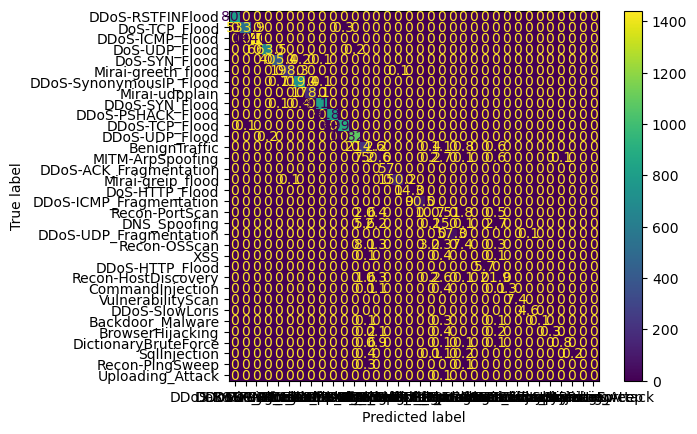

In [53]:
process_confusion_matrix(y_full_test, y_full_pred)

### Optimized

In [54]:
# redo preprocessing
best_preprocessor.fit(X_full_train)
X_full_train = pd.DataFrame(best_preprocessor.transform(X_full_train.copy()), columns=X_full_train.columns)
X_full_test = pd.DataFrame(best_preprocessor.transform(X_full_test.copy()), columns=X_full_test.columns)

# redo feature selection
X_full_train = X_full_train[best_selected_features]
X_full_test = X_full_test[best_selected_features]

# redo data balancing
X_full_train, y_full_train = fit_resample(
    X_full_train, y_full_train, best_over_threshold, best_under_threshold
)

# redo classifier building
model = build_classifier(best_model_params)

In [55]:
%%time
model.fit(X_full_train, y_full_train)
y_full_pred = model.predict(X_full_test)

CPU times: user 10h 35s, sys: 3min 21s, total: 10h 3min 56s
Wall time: 12min 54s


In [56]:
process_metrics(y_full_test, y_full_pred)

OrderedDict([   ('Accuracy', 0.9955056677957563),
                ('Precision (Macro)', 0.9152638235690784),
                ('Precision (Micro)', 0.9955056677957563),
                ('Precision (Weighted)', 0.9954326583555586),
                ('Recall (Macro)', 0.8412258803736435),
                ('Recall (Micro)', 0.9955056677957563),
                ('Recall (Weighted)', 0.9955056677957563),
                ('F1 (Macro)', 0.8686469937123039),
                ('F1 (Micro)', 0.9955056677957563),
                ('F1 (Weighted)', 0.9954264592837766)])


In [57]:
process_classification_report(y_full_test, y_full_pred)

                         precision    recall  f1-score   support

       DDoS-RSTFINFlood   0.999998  0.999926  0.999962    809057
          DoS-TCP_Flood   0.999770  0.999386  0.999578    534289
        DDoS-ICMP_Flood   0.999974  0.999965  0.999969   1440101
          DoS-UDP_Flood   0.999756  0.999744  0.999750    663719
          DoS-SYN_Flood   0.999106  0.999778  0.999442    405767
     Mirai-greeth_flood   0.998332  0.998523  0.998427    198373
DDoS-SynonymousIP_Flood   0.999921  0.999804  0.999862    719628
         Mirai-udpplain   0.999837  0.999803  0.999820    178115
         DDoS-SYN_Flood   0.999884  0.999525  0.999704    811838
      DDoS-PSHACK_Flood   0.999990  0.999935  0.999963    818951
         DDoS-TCP_Flood   0.999621  0.999850  0.999735    899533
         DDoS-UDP_Flood   0.999875  0.999819  0.999847   1082457
          BenignTraffic   0.943280  0.962739  0.952910    219639
       MITM-ArpSpoofing   0.886053  0.884930  0.885491     61519
 DDoS-ACK_Fragmentation 

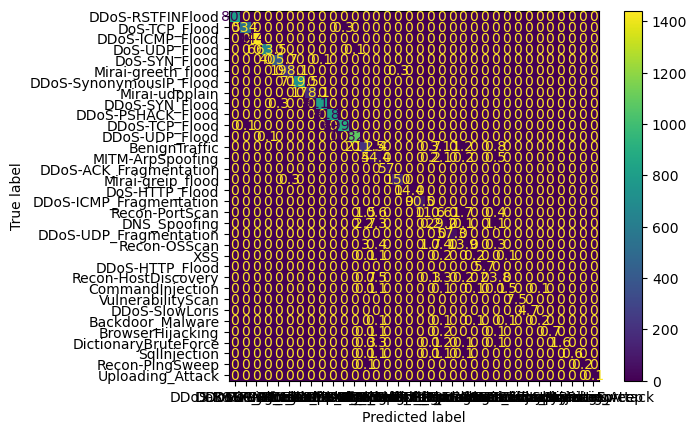

In [58]:
process_confusion_matrix(y_full_test, y_full_pred)